In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def conduction(T_h):
    L = layers[:, 0] #length or thickness of each layer
    k = layers[:, 1] #thermal conductivity per material

    R_t = np.sum(L / (k * Area)) #thermal resistance

    T_c = T_h - q * R_t #cold side temperature in K

    return T_c, R_t


#change these values (all in SI UNits):
q = 15000/48 #W, heat in one coil, based on last year
hot_temp = 85 + 273 #K, maximum temperature in the copper
layers = np.array([[3.35 * 10**-3, 401], #copper (first value is length, second value is conductivity)
                   [2 * 10**-3, 3], #epoxy. Conductvities vary wildly, 0.16-0.26 usually, 3.7 for good thermal, poor elecrical conduction (Aluminium nitride), up to 17 for silver filling (good conduction both therm and elec)
                   [0.5 * 10**-3, 237]]) #aluminium

H = 0.09
L = 0.123
W = 0.066
Area = H*L #in m^2, heightxlength of one coil

N_windings = 46

#provides answer
wall_temp, R_t = conduction(hot_temp)
delta_T_cond = hot_temp - wall_temp
wall_temp += -273 #In celsius
print(f"Temperature of the inside of the aluminium tube is {wall_temp:.2f} \u2103 and the temperature difference is {(delta_T_cond):.2f} \u2103")

Temperature of the inside of the aluminium tube is 65.88 ℃ and the temperature difference is 19.12 ℃


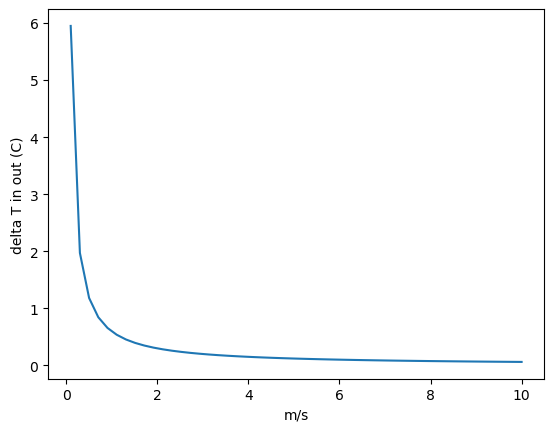

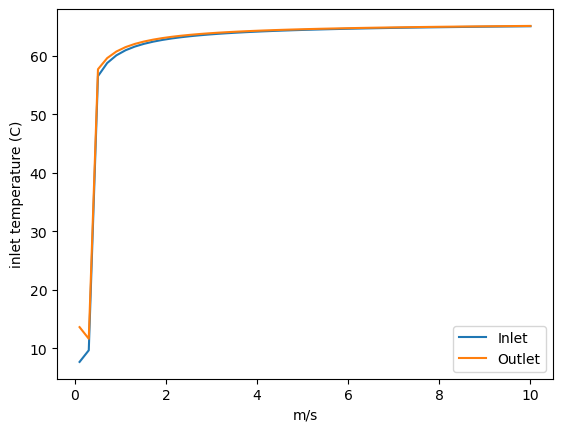

In [58]:
#Set up as a number of parallel tubes, each separately connected to the reservoir. They only cover the long sides of the coils.
method = 'parallel'
q_conv = q/Ntubes #W, amount of heat transferred in one tube
d = 4e-3 #m, inner diameter of tube
Ntubes = round(H/(d+0.003)) #number of tubes on one side of a coil
rho = 1000 #kg/m3, density water
umin = 0.1 #m/s, flow speed water
umax = 10
Nspeed = 50
u = np.linspace(umin, umax,Nspeed)
mu = 8.9e-4 #Pa s, dynamic viscoity water
Re = u*rho*d/mu #reynolds number
k = 0.6 #W/mK, conductivity water
cp = 4180 #J/kgK, specific heat water
Pr = cp * mu/k #Prandtl number
n = 0.4 #for fluid heating up, dittus boelter coefficient
Nu = np.zeros(Nspeed)
for i in range(Nspeed):
    Nu[i] = 3.66 if Re[i]<2040 else 0.023*Re[i]**0.8*Pr**n #nusselt number

L_tube = L
A_contact = 2/3 *np.pi * d * L_tube
h = Nu * k / d #heat transfer coefficient
delta_T_water_wall = q_conv / (h*A_contact) #K, temperature difference between water and wall

Aflow = 1/4 * np.pi * d**2 #m2, area that water flows through
mflow = u*Aflow*rho
delta_T_in_out = q_conv / (mflow * cp)

T_avg = wall_temp - delta_T_water_wall
T_in = T_avg - 1/2 * delta_T_in_out
T_out = T_avg + 1/2 * delta_T_in_out


plt.plot(u, delta_T_in_out)
plt.xlabel("m/s")
plt.ylabel("delta T in out (C)")
plt.show()

plt.plot(u, T_in, label="Inlet")
plt.plot(u, T_out, label="Outlet")
plt.xlabel("m/s")
plt.ylabel("inlet temperature (C)")
plt.legend()
plt.show()

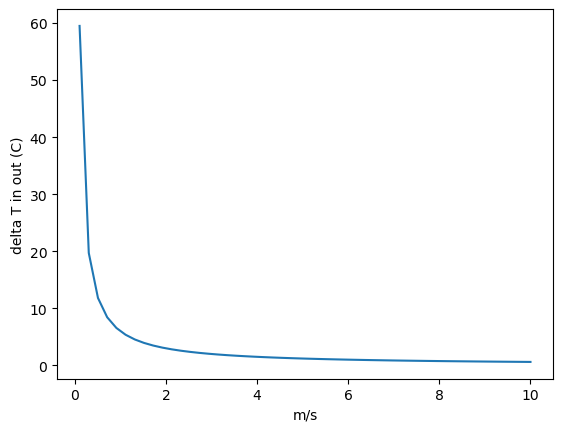

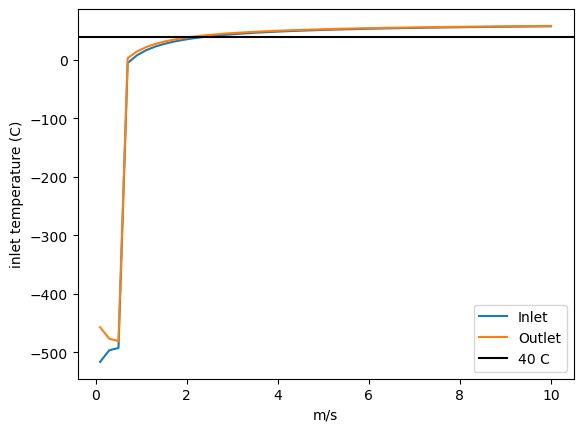

In [7]:
#Almost the same as previous method, but now the tube slithers back and forth.
method = 'series'
q_conv = q #W, amount of heat transferred
d = 4e-3 #m, inner diameter of tube
Ntubes = round(H/(d+0.005)) #number of tubes on one side of a coil, they probably need some more space for the turns.
rho = 1000 #kg/m3, density water
umin = 0.1 #m/s, flow speed water
umax = 10
Nspeed = 50
u = np.linspace(umin, umax,Nspeed)
mu = 8.9e-4 #Pa s, dynamic viscoity water
Re = u*rho*d/mu #reynolds number
k = 0.6 #W/mK, conductivity water
cp = 4180 #J/kgK, specific heat water
Pr = cp * mu/k #Prandtl number
n = 0.4 #for fluid heating up, dittus boelter coefficient
Nu = np.zeros(Nspeed)
for i in range(Nspeed):
    Nu[i] = 3.66 if Re[i]<2300 else 0.023*Re[i]**0.8*Pr**n #nusselt number

L_tube = L *Ntubes #m, L is length of one side of the coil.
A_contact = 2/3 *np.pi * d * L
h = Nu * k / d #heat transfer coefficient
delta_T_water_wall = q_conv / (h*A_contact) #K, temperature difference between water and wall

Aflow = 1/4 * np.pi * d**2 #m2, area that water flows through
Vflow = u*Aflow# interisting for pump specs
mflow = u*Aflow*rho
delta_T_in_out = q_conv / (mflow * cp)

T_avg = wall_temp - delta_T_water_wall
T_in = T_avg - 1/2 * delta_T_in_out
T_out = T_avg + 1/2 * delta_T_in_out

plt.plot(u, delta_T_in_out)
plt.xlabel("m/s")
plt.ylabel("delta T in out (C)")
plt.show()

plt.plot(u, T_in, label="Inlet")
plt.plot(u, T_out, label="Outlet")
plt.xlabel("m/s")
plt.ylabel("inlet temperature (C)")
plt.axhline(40, label="40 C", color='black')
plt.legend()
plt.show()

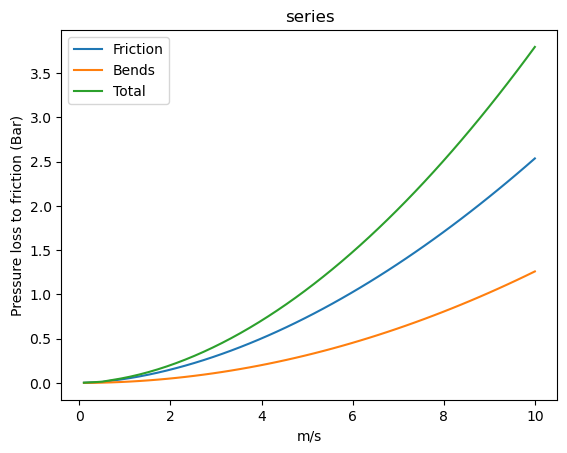

In [4]:
f = np.zeros(Nspeed)
relative_roughness = 0.0013e-3 #m, typical for new aluminium tube
def Swamee_Jain(Re):
    return 0.25 / (np.log10(relative_roughness/3.7 + 5.74/Re))**2
for i in range(Nspeed):
    f[i] = 64/Re[i] if Re[i]<2300 else Swamee_Jain(Re[i])

friction_pressure = L_tube*f*rho/2*u**2/d/10**5 #Bar, Darcy-Weisbach equation
bends_pressure = (Ntubes-1)*0.28*0.5*u**2*rho/10**5#Bar, Chris Kleijn equation or something (minor losses)
total_pressure = friction_pressure + bends_pressure
#print(f"{method} pressure loss = {friction_pressure.2f}")
plt.title(method)
plt.plot(u, friction_pressure, label="Friction")
plt.plot(u, bends_pressure, label="Bends")
plt.plot(u, total_pressure, label="Total")
plt.xlabel("m/s")
plt.ylabel("Pressure loss to friction (Bar)")
plt.legend()
plt.show()

In [17]:
#Completely different method: the short sides are cooled, heat flow from long to short is first calculated.

q_cond = q/4 #system modeled is 1/4 of a coil.
thickness_copper = layers[0,0]
k_copper = layers[0,1]
k_steelcore = 29.2 #W/mK, specsheet does not give a direction, but for this anisotropic material, that likely does matter.
W_steelcore = 38e-3 #m, width of the core

R_t = 1/(1/(L/2+W/2)/(k_copper * 1/4 * np.pi * thickness_copper**2*N_windings) + 1/((L/2+W/2)/(k_steelcore * W_steelcore/2 * H))) #including core
R_t = (L/2+W/2)/(k_copper * 1/4 * np.pi * thickness_copper**2*N_windings) #excluding core
#R_t = (L/2+W/2)/(k_copper * H * thickness_copper)
delta_T_length_wire = q_cond*R_t

print(delta_T_length_wire)

1.1906718220427837
